In [1]:
import os
import torch
import clip
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "ViT-B/32"

model, preprocess = clip.load(MODEL_NAME, device=DEVICE)
model.eval()

print("Device:", DEVICE)


Device: cuda


Selected video: Fighting002_x264
Selected segment: seg_0000
Frame path: ../segments_16/train/Fighting/Fighting002_x264/seg_0000/frame_00.png


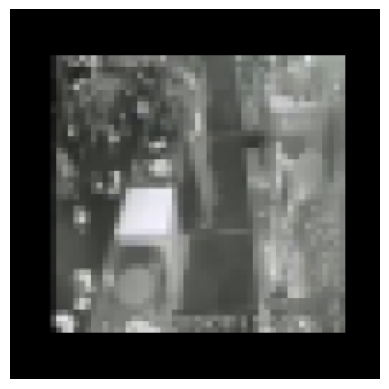

In [2]:
DATA_ROOT = "../segments_16/train"
CLASS_NAME = "Fighting"

class_dir = os.path.join(DATA_ROOT, CLASS_NAME)

video_list = sorted(os.listdir(class_dir))
first_video = video_list[0]
video_dir = os.path.join(class_dir, first_video)

segment_list = sorted(os.listdir(video_dir))
first_segment = segment_list[0]
segment_dir = os.path.join(video_dir, first_segment)

frame_list = sorted(os.listdir(segment_dir))
first_frame = frame_list[0]
image_path = os.path.join(segment_dir, first_frame)

image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")

print("Selected video:", first_video)
print("Selected segment:", first_segment)
print("Frame path:", image_path)


In [3]:
TEXTS = [
    "a person fighting",
    "people walking normally",
    "a peaceful street scene",
    "a violent action",
    "a robbery happening"
]

with torch.no_grad():
    text_tokens = clip.tokenize(TEXTS).to(DEVICE)
    text_embeddings = model.encode_text(text_tokens)
    text_embeddings = F.normalize(text_embeddings, dim=-1)

print("Text embeddings shape:", text_embeddings.shape)


Text embeddings shape: torch.Size([5, 512])


In [4]:
# Cell 7 – Segment sanity check

print("Using video directory:", video_dir)
print("Using segment directory:", segment_dir)

frame_list = sorted(os.listdir(segment_dir))
print("Total frames in segment:", len(frame_list))
print("First 3 frames:", frame_list[:3])


Using video directory: ../segments_16/train/Fighting/Fighting002_x264
Using segment directory: ../segments_16/train/Fighting/Fighting002_x264/seg_0000
Total frames in segment: 16
First 3 frames: ['frame_00.png', 'frame_01.png', 'frame_02.png']


In [5]:
def compute_segment_embedding(segment_dir):
    frame_files = sorted(os.listdir(segment_dir))
    frame_embeddings = []

    with torch.no_grad():
        for frame_name in frame_files:
            frame_path = os.path.join(segment_dir, frame_name)

            image = Image.open(frame_path).convert("RGB")
            image_input = preprocess(image).unsqueeze(0).to(DEVICE)

            emb = model.encode_image(image_input)
            frame_embeddings.append(emb)

    frame_embeddings = torch.cat(frame_embeddings, dim=0)

    segment_embedding = frame_embeddings.mean(dim=0, keepdim=True)
    segment_embedding = F.normalize(segment_embedding, dim=-1)

    return segment_embedding


In [6]:
segment_embedding = compute_segment_embedding(segment_dir)
print("Segment embedding shape:", segment_embedding.shape)


Segment embedding shape: torch.Size([1, 512])


In [7]:
similarity = segment_embedding @ text_embeddings.T

for i, text in enumerate(TEXTS):
    print(f"{text:30s} : {similarity[0][i].item():.4f}")


a person fighting              : 0.2341
people walking normally        : 0.2299
a peaceful street scene        : 0.1921
a violent action               : 0.2272
a robbery happening            : 0.2244


In [8]:
video_dir = os.path.join(class_dir, sorted(os.listdir(class_dir))[0])

segment_dirs = sorted([
    os.path.join(video_dir, d)
    for d in os.listdir(video_dir)
])

print("Total segments:", len(segment_dirs))
print("First segments:", segment_dirs[:3])


Total segments: 16
First segments: ['../segments_16/train/Fighting/Fighting002_x264/seg_0000', '../segments_16/train/Fighting/Fighting002_x264/seg_0001', '../segments_16/train/Fighting/Fighting002_x264/seg_0002']


In [9]:
def segment_zero_shot_score(segment_dir, text_embeddings, class_texts):
    seg_emb = compute_segment_embedding(segment_dir)
    seg_emb = F.normalize(seg_emb, dim=-1)

    sims = seg_emb @ text_embeddings.T
    max_score, best_idx = sims.max(dim=1)

    return {
        "segment": os.path.basename(segment_dir),
        "best_class": class_texts[best_idx.item()],
        "score": max_score.item()
    }


In [10]:
results = [
    segment_zero_shot_score(seg_dir, text_embeddings, TEXTS)
    for seg_dir in segment_dirs
]

results[:5]


[{'segment': 'seg_0000',
  'best_class': 'a person fighting',
  'score': 0.234130859375},
 {'segment': 'seg_0001',
  'best_class': 'a person fighting',
  'score': 0.2337646484375},
 {'segment': 'seg_0002',
  'best_class': 'a person fighting',
  'score': 0.2322998046875},
 {'segment': 'seg_0003',
  'best_class': 'a person fighting',
  'score': 0.233642578125},
 {'segment': 'seg_0004',
  'best_class': 'people walking normally',
  'score': 0.2337646484375}]

In [11]:
results_sorted = sorted(results, key=lambda x: x["score"], reverse=True)

print("Top 10 segments by similarity:\n")
for r in results_sorted[:10]:
    print(r)


Top 10 segments by similarity:

{'segment': 'seg_0000', 'best_class': 'a person fighting', 'score': 0.234130859375}
{'segment': 'seg_0001', 'best_class': 'a person fighting', 'score': 0.2337646484375}
{'segment': 'seg_0004', 'best_class': 'people walking normally', 'score': 0.2337646484375}
{'segment': 'seg_0003', 'best_class': 'a person fighting', 'score': 0.233642578125}
{'segment': 'seg_0014', 'best_class': 'a person fighting', 'score': 0.2332763671875}
{'segment': 'seg_0010', 'best_class': 'people walking normally', 'score': 0.23291015625}
{'segment': 'seg_0002', 'best_class': 'a person fighting', 'score': 0.2322998046875}
{'segment': 'seg_0011', 'best_class': 'people walking normally', 'score': 0.232177734375}
{'segment': 'seg_0015', 'best_class': 'a person fighting', 'score': 0.231689453125}
{'segment': 'seg_0009', 'best_class': 'a person fighting', 'score': 0.23046875}


In [12]:
ANOMALY_CLASSES = [
    "a person fighting",
    "a violent action",
    "a robbery happening"
]

top_k = 5
top_segments = results_sorted[:top_k]

anomaly_votes = sum(
    1 for r in top_segments
    if r["best_class"] in ANOMALY_CLASSES
)

print("\nTop segments:")
for r in top_segments:
    print(r)

print("\nAnomaly votes:", anomaly_votes, "/", top_k)

if anomaly_votes >= (top_k // 2 + 1):
    print("VIDEO DECISION: ANOMALOUS")
else:
    print("VIDEO DECISION: NORMAL")



Top segments:
{'segment': 'seg_0000', 'best_class': 'a person fighting', 'score': 0.234130859375}
{'segment': 'seg_0001', 'best_class': 'a person fighting', 'score': 0.2337646484375}
{'segment': 'seg_0004', 'best_class': 'people walking normally', 'score': 0.2337646484375}
{'segment': 'seg_0003', 'best_class': 'a person fighting', 'score': 0.233642578125}
{'segment': 'seg_0014', 'best_class': 'a person fighting', 'score': 0.2332763671875}

Anomaly votes: 4 / 5
VIDEO DECISION: ANOMALOUS


In [13]:
THRESHOLD = 0.23

high_conf_segments = [
    r for r in results_sorted
    if r["score"] > THRESHOLD and r["best_class"] in ANOMALY_CLASSES
]

print("\nHigh confidence anomaly segments:", len(high_conf_segments))

if len(high_conf_segments) > 0:
    print("VIDEO DECISION (Threshold): ANOMALOUS")
else:
    print("VIDEO DECISION (Threshold): NORMAL")



High confidence anomaly segments: 7
VIDEO DECISION (Threshold): ANOMALOUS
